# Causality for trends in popular Reddit posts

Do popular posts on /r/dataisbeautiful inspire copy cats?

In [32]:
import requests
import requests.auth
import praw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Set up the OAuth2 credentials for the Reddit API

https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example

In [33]:
# Load the credentials file
credentials = {}
with open("credentials.txt", "r") as infile:
    for line in infile.readlines():
        key, val = line.strip().split(": ")
        credentials[key] = val

In [3]:
# Request a token
client_auth = requests.auth.HTTPBasicAuth(credentials["client_id"], credentials["secret"])
post_data = {"grant_type": "password", "username": credentials["username"], "password": credentials["password"]}
user_agent = f"reddit_api_python by {credentials['username']}"
headers = {"User-Agent": user_agent}
uri = "https://www.reddit.com/api/v1/access_token"
response = requests.post(uri, auth=client_auth, data=post_data, headers=headers)

In [4]:
# Test that the token is working
auth = " ".join(response.json()[key] for key in ["token_type", "access_token"])
headers = {"Authorization": auth, "User-Agent": user_agent}
uri = "https://oauth.reddit.com/api/v1/me"
r = requests.get(uri, headers=headers)
assert r.status_code == 200, "Status code != 200."

## Open the Reddit API connection

In [6]:
reddit = praw.Reddit(client_id=credentials["client_id"],
                     client_secret=credentials["secret"],
                     password=credentials["password"],
                     username=credentials["username"],
                     user_agent=user_agent)
reddit

# Search the subreddit

In [8]:
%%time
subreddit = reddit.subreddit("dataisbeautiful")
search_terms = ["sankey", "tinder", "budget", "monthly", "expenses"]
results = []
for query in search_terms:
    search = subreddit.search(query, sort="new", limit=None)
    results.extend(list(search))
    print(f"Found {len(results)} results for '{query}'.")

Found 82 results for 'sankey'.
Found 134 results for 'tinder'.
Found 316 results for 'budget'.
Found 536 results for 'monthly'.
Found 617 results for 'expenses'.


## Convert to `pandas` DataFrame

In [46]:
# Format the search results as a list of dictionaries
posts = [r.__dict__ for r in results]

# Create the DataFrame
columns = ["author", "title", "ups", "downs",
           "clicked", "created_utc",
           "edited", "id", "is_self", "link_flair_template_id",
           "link_flair_text", "locked", "name", "num_comments",
           "over_18", "permalink", "score", "selftext", "spoiler",
           "stickied", "subreddit", "url", "distinguished"]
data = (pd.DataFrame(posts)
          .loc[:, columns]
          .drop_duplicates(subset="permalink")
          .sort_values(by="created_utc", ascending=True))
data.head(2)

,author,title,ups,downs,clicked,created_utc,edited,id,is_self,link_flair_template_id,...,num_comments,over_18,permalink,score,selftext,spoiler,stickied,subreddit,url,distinguished
315,zanycaswell,An interactive representation of Pres. Obamas ...,21,0,False,1.329265e+09,False,ppx09,False,NaN,...,0,False,/r/dataisbeautiful/comments/ppx09/an_interacti...,21,,False,False,dataisbeautiful,http://www.nytimes.com/interactive/2012/02/13/...,None
314,zanycaswell,A 31 year old Shanghai office workers budget,45,0,False,1.331730e+09,False,qw3nf,False,NaN,...,6,False,/r/dataisbeautiful/comments/qw3nf/a_31_year_ol...,45,,False,False,dataisbeautiful,http://www.sankey-diagrams.com/wp-content/gall...,None


# Make a plot

In [59]:
def term_is_in_comments(post, term):
    """Returns true if any comment in the post inclues the given term"""
    comments = post.comments.list()
    for comment in comments:
        if isinstance(comment, praw.models.reddit.more.MoreComments):
            comments.extend(comment.comments())
        elif term in comment.body.lower():
            print(comment.body)
            return True
    return False

In [60]:
def contains_same_topic(post, topic):
    """Checks if a given post contains the same topic as the specified post"""
    pass

In [61]:
def check_topics(post):
    topics = set()
    for term in search_terms:
        if term.lower() in post.title.lower():
            topics.add(term)
    return topics

In [62]:
def number_of_followup_posts(post, weeks_after_post=1):
    utc = post.created_utc
    window = weeks_after_post * 7 * 24 * 60 * 60 # convert to seconds
    mask = (data.created_utc > utc) & (data.created_utc <= (utc + window))
    
    # Check if the posts are actually follow ups
    original_topics = check_topics(post)
    if any(mask):
        followups = data[mask]
        return sum(followups.apply(check_topics, axis=1).apply(lambda x: len(x.intersection(original_topics)) > 0))
    else:
        return 0

In [63]:
%%time
data["number_of_followup_posts"] = data.apply(number_of_followup_posts, axis=1)

CPU times: user 3.81 s, sys: 33.3 ms, total: 3.84 s
Wall time: 3.97 s


# Only look at popular posts

We will assume that a post needs at least **N** upvotes to be popular, potentially inspiring copycat posts.

In [73]:
num_upvotes = 100
popular = data[data.ups >= num_upvotes]
print(f"We have {len(popular)} posts with {num_upvotes} or more upvotes.")

We have 83 posts with 100 or more upvotes.


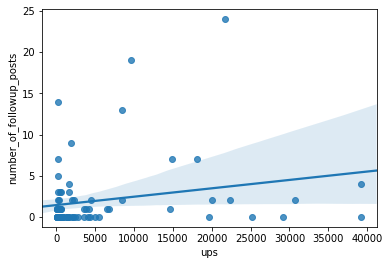

In [75]:
sns.regplot(data=popular, x="ups", y="number_of_followup_posts")

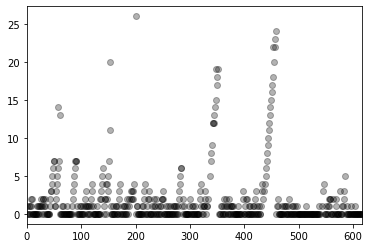

In [95]:
data.number_of_followup_posts.plot(kind='line', style='ko', alpha=0.3)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 5205,  4819,  5538,  5456,  6115,  6142,  7222,  7289,  8073,
         8095, 10212,  8095,  8073,  7289,  7222,  6142,  6115,  5456,
         5538,  4819,  5205]),
 <matplotlib.lines.Line2D at 0x124fe61d0>)

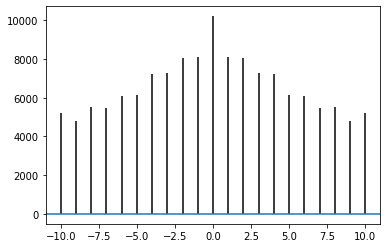

In [103]:
plt.acorr(data.number_of_followup_posts, normed=False)

In [131]:
data[["ups", "number_of_followup_posts"]].corr()

,ups,number_of_followup_posts
ups,1.000000,0.089217
number_of_followup_posts,0.089217,1.000000


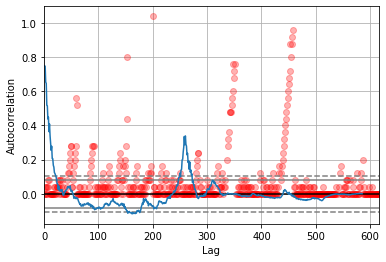

In [128]:
ax = (data.number_of_followup_posts / 25).plot(kind='line', style='ro', alpha=0.3)
pd.plotting.autocorrelation_plot(data.set_index("created_utc").number_of_followup_posts, ax=ax)
plt.show()

In [ ]:
data.number_of_followup_posts.a

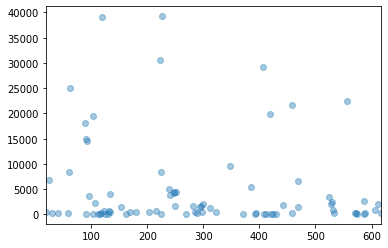

In [110]:
popular.ups.plot(kind='line', style='o', alpha=0.4)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 874408718, 2096659388, 2461232383, 1298489531, 1548233526,
        1945225274, 1087868966, 3372447528, 2693743536, 1110862833,
        8559479318, 1110862833, 2693743536, 3372447528, 1087868966,
        1945225274, 1548233526, 1298489531, 2461232383, 2096659388,
         874408718]),
 <matplotlib.lines.Line2D at 0x126728a20>)

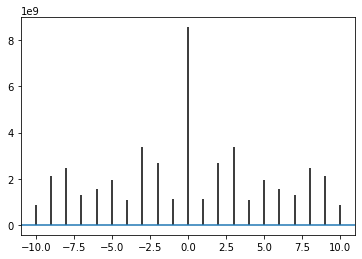

In [111]:
plt.acorr(popular.ups, normed=False)

In [97]:
plt.acorr?

Signature: plt.acorr(x, *, data=None, **kwargs)
Docstring:
Plot the autocorrelation of *x*.

Parameters
----------
x : array-like

detrend : callable, optional, default: `mlab.detrend_none`
    *x* is detrended by the *detrend* callable. This must be a
    function ``x = detrend(x)`` accepting and returning an
    `numpy.array`. Default is no normalization.

normed : bool, optional, default: True
    If ``True``, input vectors are normalised to unit length.

usevlines : bool, optional, default: True
    Determines the plot style.

    If ``True``, vertical lines are plotted from 0 to the acorr value
    using `Axes.vlines`. Additionally, a horizontal line is plotted
    at y=0 using `Axes.axhline`.

    If ``False``, markers are plotted at the acorr values using
    `Axes.plot`.

maxlags : int, optional, default: 10
    Number of lags to show. If ``None``, will return all
    ``2 * len(x) - 1`` lags.

Returns
-------
lags : array (length ``2*maxlags+1``)
    The lag vector.
c : array  

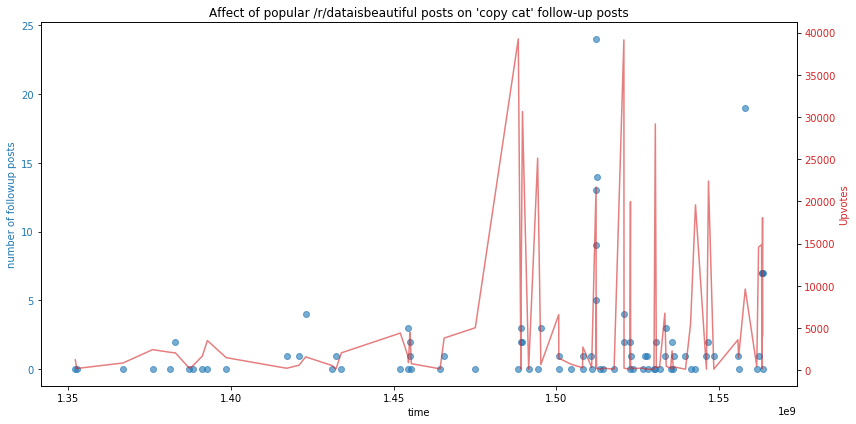

In [86]:
t = popular["created_utc"]

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('number of followup posts', color=color)
ax1.plot(t, popular["number_of_followup_posts"], 'o', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Upvotes', color=color)  # we already handled the x-label with ax1
ax2.plot(t, popular["ups"], color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Affect of popular /r/dataisbeautiful posts on 'copy cat' follow-up posts")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

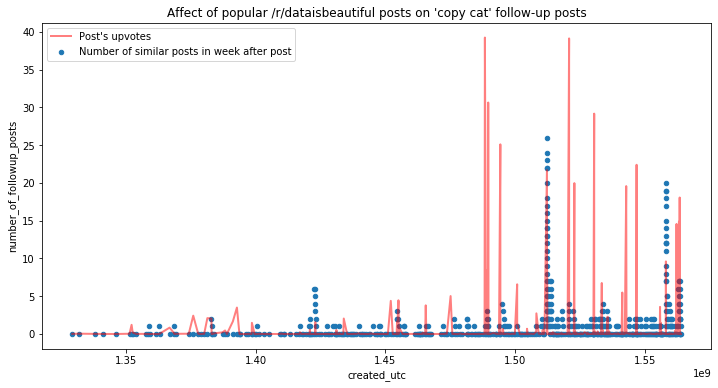

In [76]:
# mask = (data.created_utc > 1.47e9) & (data.ups > 50)
# mask = (data.created_utc > 1.51e9) & (data.ups >= 0) & (data.created_utc < 1.52e9)
ax = data.plot.scatter(*["created_utc", "number_of_followup_posts"], figsize=(12, 6))
ax.plot(data["created_utc"], data["ups"] / 1000, "r", alpha=0.5, linewidth=2)
ax.legend(["Post's upvotes", "Number of similar posts in week after post"])
ax.set_title("Affect of popular /r/dataisbeautiful posts on 'copy cat' follow-up posts")
# ax.set_xlim([1.51e9, 1.52e9])
plt.show()

In [26]:
N = 5
mask = data.ups >= 5
[print("reddit.com" + p) for p in data[mask].sort_values(by="number_of_followup_posts", ascending=False).head(N).permalink];

reddit.com/r/dataisbeautiful/comments/7hb299/our_monthly_budget_austin_tx_usa_oc/
reddit.com/r/dataisbeautiful/comments/7h99vj/where_my_monthly_paycheck_goes_japan_countryside/
reddit.com/r/dataisbeautiful/comments/7hajbn/where_my_monthly_income_goes_as_a_british_student/
reddit.com/r/dataisbeautiful/comments/7hasru/where_my_monthly_income_goes_as_a_single_parent/
reddit.com/r/dataisbeautiful/comments/bpof9r/how_a_monthly_belgian_household_budget_of_7350_is/
